# SENSITIVITY ANALYSIS
The preliminary results in our IMAGEN paper advocates for a more in-depth understanding of what contributes to the significant performance of the ML models for the three time-points. Here we will throw several what-if questions at the analysis to help us understand better how the ML models worked.

1. Why do the 10 AAM labels have widely different accuracies? 
2. Are all 4 ML models consistent with one another?
3. Are the same subjects mis-predicted at all 3 timepoints?
4. Where the results specifically good for some sites and bad for some others? Across the 4 models? does the finding generalize to holdout?

Two evidence that hints towards the fact that the 'site' confounds may be the reason for the significant accuracy and was not still removed: 
1. Leave-one-site-out CV did not work
2. Performing the chi-squared test between the 2 confounds and the label (c\mapsto y) for all the AAM labels derived show mixed results. <br>
You can see this result in section 1.4 in plot_results.ipynb .  <br>
Similarly, using the PBCC technique of Dinga et al. showed that the confounds could explain a major portion of the variance in the model accuracy on the holdout set. This still does not prove that the confounds were the cause for the high accuracy but it does raise suspicion.  

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np
from glob import glob
from os.path import join 
import os, sys
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

Helper functions

In [32]:
# load all the labels used in the study as one pandas dataframe along with sex and site and subject ID information
import os, sys, inspect 
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
from imagen_dataloader import *

def load_all_labels():
    lbl_combinations = [  
        ("ESPAD_FU3",        '19a',        3, 6,   'Binge'),
        ("ESPAD_GM_FINE",  'cluster',   2, 6,   'Binge_growth'),
        ("PHENOTYPE",      'Phenotype', 0, 2,   'Combined_seo'),
        ("OUR_COMBO",      'cluster', 0, 2,   'Combined_ours'),
        (f"AUDIT_FU3",     'audit_total', 4, 8,   'AUDIT'),
        (f"AUDIT_FU3",     'audit_freq', 3, 6,   'AUDIT_quick'),
        ("AUDIT_GM_FINE",  "cluster", [0,3], [2,5,6], 'AUDIT_growth'),
        ("ESPAD_FU3",      '29d', [16,17,18,19,20,21], [11,12,13,14],   'onset<15'),
        ("ESPAD_FU3", '8b', 4, 6, 'Frequency'),
        (f"AUDIT_FU3",   'audit2', 0, 2, 'Amount'),
    ]

    final_df = pd.DataFrame(index=Imagen(exclude_holdout=False).df_out.index)

    x_tp = "FU3" #, "FU2", "BL"
    lbl_combos = lbl_combinations
    name = ""
    use_all_data=True
    viz=0
    feature_cols=".+"
    confs=['sex','site']

    for i, (csv, col, c0, c1, colname) in enumerate(lbl_combos):
        if use_all_data:
            d = Imagen(exclude_holdout=False)
        elif use_only_holdout:  
            d = Imagen()
            d.df = d.df_holdout
            d.df_out = pd.DataFrame(index=d.df_holdout.index)
        else:
            d = Imagen()         

        if qs_is_raw_csv[csv]:
            dfq = pd.read_csv(qs[csv], usecols=["User code", col], dtype={"User code":str})
            dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
            dfq = dfq.drop("User code", axis=1)
        else:
            dfq = pd.read_csv(qs[csv], usecols=["ID", col])

        d.load_label(dfq, col=col, viz=(viz>1), binarize=True, class0=c0, class1=c1, y_colname=colname)
        # from x.prepare_X() get the subject IDS to filter out the right subjects
        feature = pd.read_csv(join(d.DATA_DIR, f"IMAGEN_BIDS/sMRI-derivatives_{x_tp}.csv"), index_col="ID")
        # filter columns
        feature = feature.filter(regex=feature_cols)
        d.df_out = d.df_out.loc[feature.index] 

        d.df_out[d.all_labels[0]] = d.df_out[d.all_labels[0]].map({0:0, np.nan:1, 1:2})
    #         print(csv, len(feature.index))
        final_df[d.all_labels[0]] = d.df_out[d.all_labels[0]]

        # also get the confounds: add sex and site confounds
        if i==0:
            final_df[confs] = d.df[x_tp][confs]
            # remap sex values
            final_df['sex'] = final_df['sex'].map({'M':'Male','F':'Female'})
            final_df['site'] = final_df['site'].apply(lambda x: x.title())

        if viz: 
            plt.show()


    confs=['Sex','Site']
    final_df = final_df.rename(columns={'onset<15':'Onset', 'sex':confs[0], 'site':confs[1]})
    final_df = final_df.dropna()
    
    return final_df

In [56]:
### Store all predicted probablities from all models as one pandas dataframe each for each of the timepoints
def load_all_model_preds(df_all_labels):
    all_model_predictions = {}
    for tp in ['fu3', 'fu2', 'bl']:

        df_model_results = df_all_labels[['Binge', 'Sex', 'Site']] 
        # add the 4 model predictions
        results = pd.read_csv(sorted(glob(f"../MLpipelines/results/newlbls-{tp}-espad-fu3-19a-binge-*/*/run.csv"))[-1])

        # drop conf-based experiments and non-conf-controlled experiments
        results = results[(results['technique']=='cb') & ~results['i_is_conf'] & ~results['o_is_conf']]
        # load the holdout
        holdout = pd.read_csv("../MLpipelines/results/holdout_all-tp_run.csv")
        holdout = holdout[(holdout['tp']==tp) & (holdout['technique']=='cb') & ~holdout['i_is_conf'] & ~holdout['o_is_conf']].drop(columns=["Unnamed: 0", "tp"])
        results = results.merge(holdout, how='outer', on=[c for c in holdout.columns if c in results.columns])

        for i, (model, dfi) in enumerate(results.groupby(["model"])):
            # get the test IDs from all 7 trials as one numpy array
            ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])    
            # merge the holdout IDs
            # select the row (out of the 7 trials) with the best ROC_AUC score
            dfi_hold = holdout[holdout['model']==model].sort_values('holdout_roc_auc', ascending=False).iloc[0]
            ids_all_hold = np.array(eval(dfi_hold["holdout_ids"]))   
            ids_all = np.concatenate([ids_all, ids_all_hold])
        #     print(model, dfi_hold['holdout_score'], ids_all_hold)
            assert ids_all.shape[0] == np.unique(ids_all).shape[0] # just verify everything is fine

            # load the model prediction probabilities
            pred_probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])[:,1]
            # get also holdout
            pred_probs_all_hold = np.array(eval(dfi_hold["holdout_preds"]))[:,1]
            pred_probs_all = np.concatenate([pred_probs_all, pred_probs_all_hold])   
            # binarize the probability to get predicted class
            y_pred_all = (pred_probs_all>0.5).astype(int)
            y_true_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
            y_true_all_hold = np.array(eval(dfi_hold["holdout_lbls"]))
            y_true_all = np.concatenate([y_true_all, y_true_all_hold])   
            assert y_pred_all.shape[0] == y_true_all.shape[0] # just verify everything is fine
            data = pd.DataFrame(index=ids_all, data={model:y_pred_all, model+'_prob':pred_probs_all})
            df_model_results = df_model_results.join(data)
        # append the y_true values
        df_model_results[LABEL] = pd.Series({ids:y_true for ids, y_true in zip(ids_all, y_true_all)})
    #     display(tp, df_model_results)
        all_model_predictions.update({tp:df_model_results})
        
    return all_model_predictions

## Visualize agreements between the 10 AAM labels

In [34]:
df_all_labels = load_all_labels()
df_all_labels

,Binge,Sex,Site,Binge_growth,Combined_seo,Combined_ours,AUDIT,AUDIT_quick,AUDIT_growth,Onset,Frequency,Amount
ID,,,,,,,,,,,,
112288,2.0,Male,Paris,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
215284,0.0,Female,Nottingham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240546,1.0,Male,Berlin,1.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,0.0
297685,2.0,Female,Nottingham,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0
308867,2.0,Male,Nottingham,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99677574,0.0,Female,Berlin,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99873252,2.0,Female,Berlin,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
99875982,0.0,Female,London,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# plot the correlations between the different labels
corr = df_all_labels.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
display(corr.style.background_gradient(axis=None, vmin=0, vmax=1).highlight_null(null_color='#f1f1f1').format(precision=2))  # Color NaNs grey

,Binge,Binge_growth,Combined_seo,Combined_ours,AUDIT,AUDIT_quick,AUDIT_growth,Onset,Frequency,Amount
Binge,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Binge_growth,0.55,nan,nan,nan,nan,nan,nan,nan,nan,nan
Combined_seo,0.58,0.50,nan,nan,nan,nan,nan,nan,nan,nan
Combined_ours,0.68,0.52,0.48,nan,nan,nan,nan,nan,nan,nan
AUDIT,0.61,0.49,0.52,0.67,nan,nan,nan,nan,nan,nan
AUDIT_quick,0.59,0.49,0.51,0.69,0.81,nan,nan,nan,nan,nan
AUDIT_growth,0.61,0.44,0.57,0.62,0.83,0.76,nan,nan,nan,nan
Onset,0.29,0.25,0.23,0.23,0.19,0.20,0.14,nan,nan,nan
Frequency,0.51,0.44,0.44,0.45,0.56,0.59,0.50,0.10,nan,nan
Amount,0.39,0.32,0.27,0.67,0.52,0.61,0.47,0.16,0.16,nan


In [41]:
from matplotlib.lines import Line2D

def make_legend_lines(values, cmap):
    return [Line2D([], [], color=cmap(v), 
                    marker='|', ls='None', 
                    markersize=20, markeredgewidth=3) for v in values]

def plot_subject_classes(dfx, ax, confs=[], sort_order=[], lw=10, title='', fs=16, cmap=plt.cm.hot_r):
    
    df = dfx.copy()
    if sort_order: df= df.sort_values(sort_order) 
        
    legs = []
    # generate for confounds first
    cmap_conf=plt.cm.tab10
    leg_loc = ['lower right', 'center right']
    for ii, lbl in enumerate(confs):
        # convert the values to categorical values|
        indices = df[lbl].astype("category").cat.codes
        # Visualize the results
        ax.scatter(range(len(indices)), [ii+.5]*len(indices),
                   c=[cmap_conf(i) for i in indices],
                   marker='_', lw=lw)
        leg = ax.legend(make_legend_lines(indices.unique(), cmap=cmap_conf), 
                    df[lbl].unique(),
                    fontsize=fs, title=lbl.title(),
                    bbox_to_anchor=(1.182,0.17+0.4*ii))#, loc=leg_loc[ii])
        plt.setp(leg.get_title(),fontsize=fs+2)
        legs.extend([leg])
        
    # drop the confounds now
    df = df[[c for c in df.columns if c not in confs]]  
    
    # generate for labels (all the remaining columns)
    if sort_order:
        df = df.reindex(reversed(sort_order), axis=1)
    
    for ii, lbl in enumerate(df):
        # if categorical value convert to continuous for cmap
        vals = np.unique(df[lbl])
        if vals[-1]>1:
            cmap_val = np.arange(vals[0], vals[-1]+1)/(vals[-1]+0.01)+0.2
#             print(lbl, vals[-1], cmap_val)
            indices = df[lbl].apply(lambda x: cmap_val[int(x)]).values
        else:
            indices = df[lbl]
        # Visualize the results
        ax.scatter(range(len(indices)), [ii+len(confs)+.5]*len(indices),
                   c=[cmap(i) for i in indices],
                   marker='_', lw=lw, cmap=cmap, edgecolors='grey',
                   label=lbl)
        
    ax.set_yticks(np.arange(len(confs)+len(df.columns)) + .5)
    ax.set_yticklabels(confs+df.columns.values.tolist(), fontsize=fs)
    ax.set_xticklabels([])
    ax.set_ylabel('AAM phenotypes', fontsize=fs+1)
    ax.set_xlabel('subjects', fontsize=fs+1)
    ax.set_xlim([0, len(df)])
    
    if np.unique(df[lbl])[-1]>1:
        leg3 = plt.legend(
                make_legend_lines(cmap_val[::-1], cmap=cmap), 
                ['Risky','Moderate','Safe'],
                fontsize=fs, 
                title="Alcohol user \ncategory",
                bbox_to_anchor=(1.182, 1), 
                loc="upper right")
        plt.setp(leg3.get_title(),fontsize=fs+2)
        # add the other conf legends
        [ax.add_artist(leg) for leg in legs]
    else:
        pass
    # todo
    
    plt.title(title, fontsize=fs+2)
    
    return ax

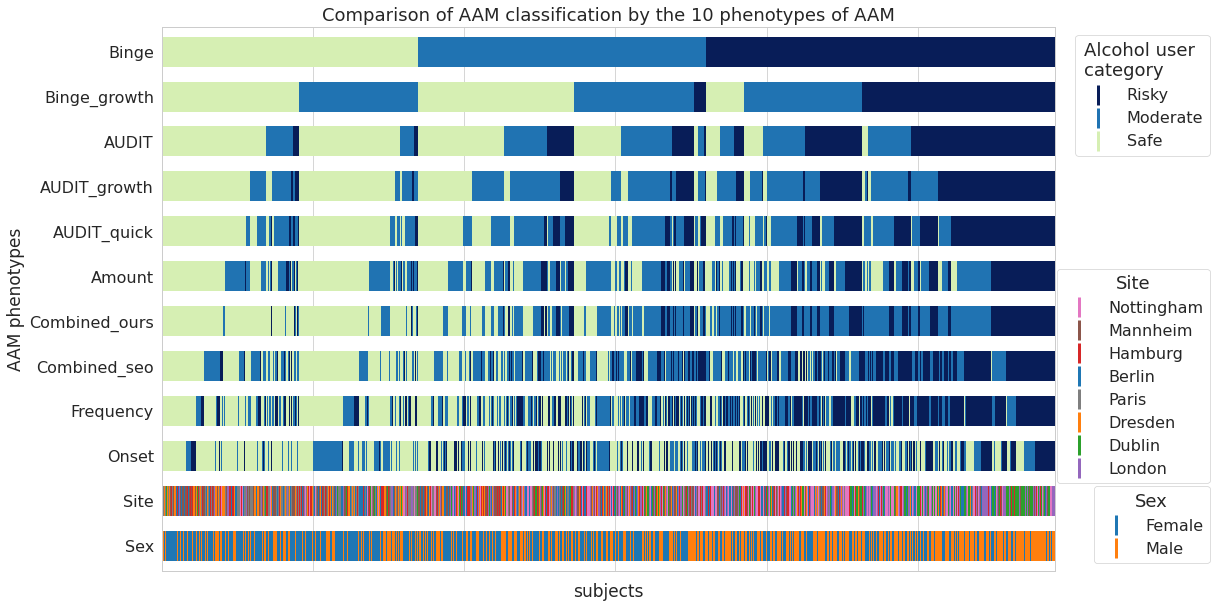

In [42]:
##################################################################################################
# sort_order = ["Binge", "Binge_growth", "Combined_ours", 
#               "Combined_seo", "AUDIT", "AUDIT_quick", "AUDIT_growth",
#               "Frequency", "Amount", "onset<15"]
sort_order =  [n for n in sorted(df_all_labels.columns) if "binge" in n.lower()] + \
[n for n in sorted(df_all_labels.columns) if ("binge" not in n.lower()) and (n not in confs)] 
# sort_order = list(reversed(sort_order))
# print(sort_order)
fig, ax = plt.subplots(figsize=(16,len(sort_order)))

plot_subject_classes(df_all_labels, ax, confs=confs,
                     sort_order=sort_order, 
                     title="Comparison of AAM classification by the 10 phenotypes of AAM",
                     lw=30, cmap=plt.cm.YlGnBu)
plt.show()

## Consistency across the 4 ML models  
for the `binge` AAM phenotype

In [43]:
sys.path.insert(1, '../MLpipelines/')
from plotResults import *

In [44]:
LABEL = 'Binge'
MODELS=["GB","SVM-rbf","SVM-lin","LR"]

### holdout results consistent within a model across 7x runs?
with different hyperparameter settings and random_seed

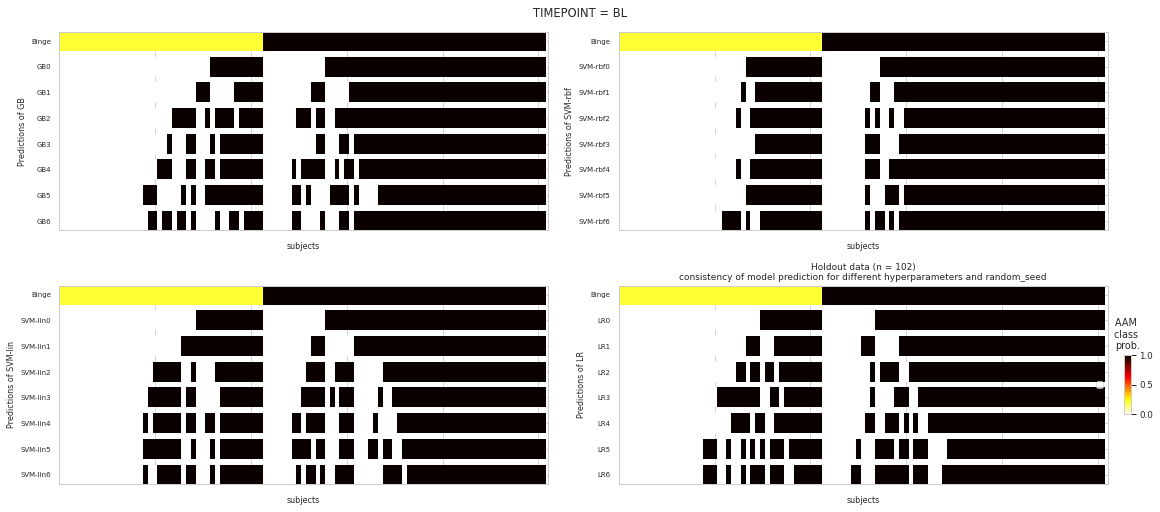

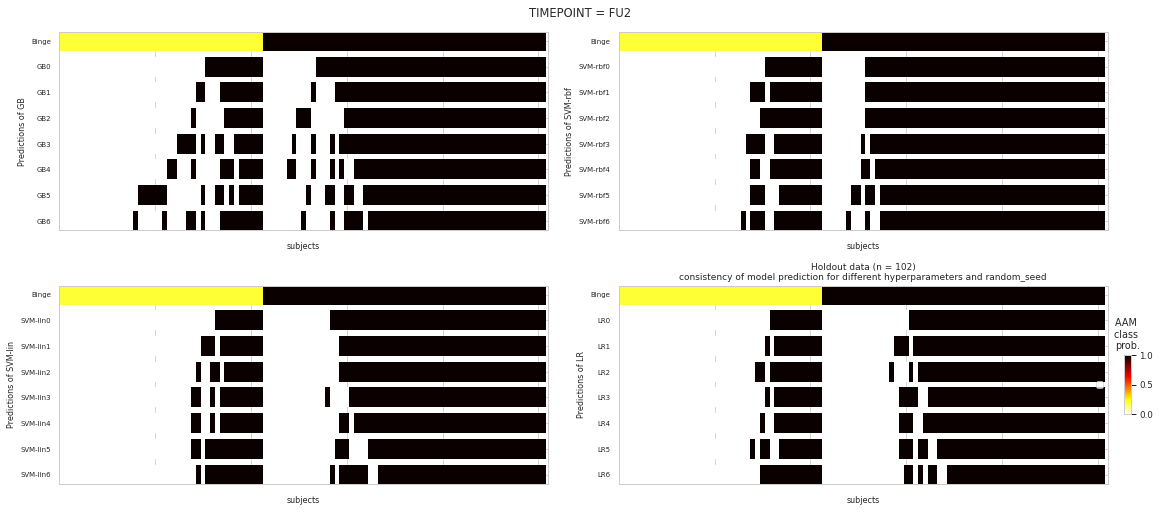

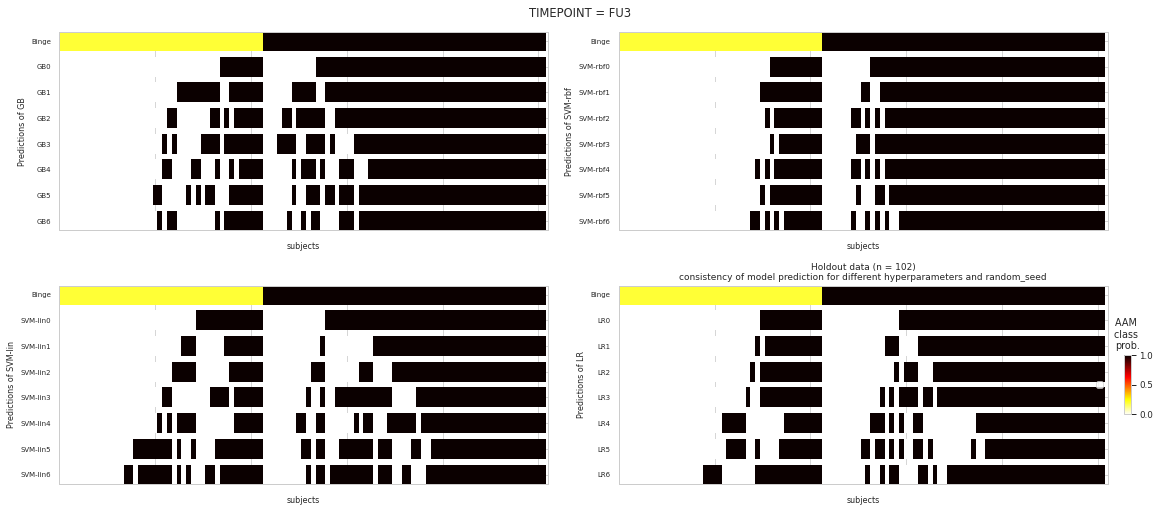

In [45]:
import matplotlib as mpl

USE_PROBS = False

# load the holdout
df_hold = pd.read_csv("../MLpipelines/results/holdout_all-tp_run.csv")
df_hold = df_hold[(df_hold['technique']=='cb') & ~df_hold['i_is_conf'] & ~df_hold['o_is_conf']].drop(columns=["Unnamed: 0"])

for tp, df_hold_tp in (df_hold.groupby(['tp'])):
    df_model_results = df_all_labels[[LABEL]] # use df_all_labels computed before
    # change the trial ID to reflect model accuracy
    for model, holdout in df_hold_tp.groupby(['model']):
        holdout['trial'].replace({t:i for i,t in enumerate(holdout.sort_values('holdout_roc_auc', ascending=False)['trial'])}, inplace=True)
        for trial, dfi in holdout.groupby(['trial']):
            ids_all = np.array([id_lists for ids in dfi["holdout_ids"] for id_lists in eval(ids)])
            assert ids_all.shape[0] == np.unique(ids_all).shape[0]
            pred_probs_all = np.array([prob_lists for probs in dfi["holdout_preds"] for prob_lists in eval(probs)])[:,1]
            y_pred_all = (pred_probs_all>0.5).astype(int)
            y_true_all = np.array([y_lists for y in dfi["holdout_lbls"] for y_lists in eval(y)])
            assert y_pred_all.shape[0] == y_true_all.shape[0]
            data = pred_probs_all if USE_PROBS else y_pred_all
            data = pd.DataFrame(index=ids_all, data={str(model)+str(trial):data})
            df_model_results = df_model_results.join(data)

    df_model_results = df_model_results.dropna()
    # # plot the correlations between the different models
    # corr = df_model_results.corr()
    # # Fill diagonal and upper half with NaNs
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True
    # corr[mask] = np.nan
    # (corr.style.background_gradient(axis=None, vmin=0, vmax=1).highlight_null(null_color='#f1f1f1')).set_precision(2)  # Color NaNs grey

    fig, axes = plt.subplots(2,2, figsize=(16,len(df_model_results.columns)//4) , constrained_layout=True)
    fig.suptitle(f"TIMEPOINT = {tp.upper()}")
    cmap = plt.cm.hot_r
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap),
        shrink=0.3, location='right')
    cbar.ax.set_title('AAM \nclass \nprob.')
    
    for i,model in enumerate(MODELS):
        dfi = df_model_results[[c for c in df_model_results.columns if (c ==LABEL) or (model.lower() in c.lower())]]
        sort_order = sorted(dfi.columns)
        ax = plot_subject_classes(dfi,
                             ax=np.ravel(axes)[i],
                             sort_order=sort_order,
                             lw=20, fs=7, cmap=cmap,
        title=f"Holdout data (n = {len(dfi)})\nconsistency of model prediction for different hyperparameters and random_seed")
        ax.set_ylabel(f"Predictions of {model}")
        plt.legend([])
    plt.show()

### How does the prediction probabilitiy distribution of the 4 models look?

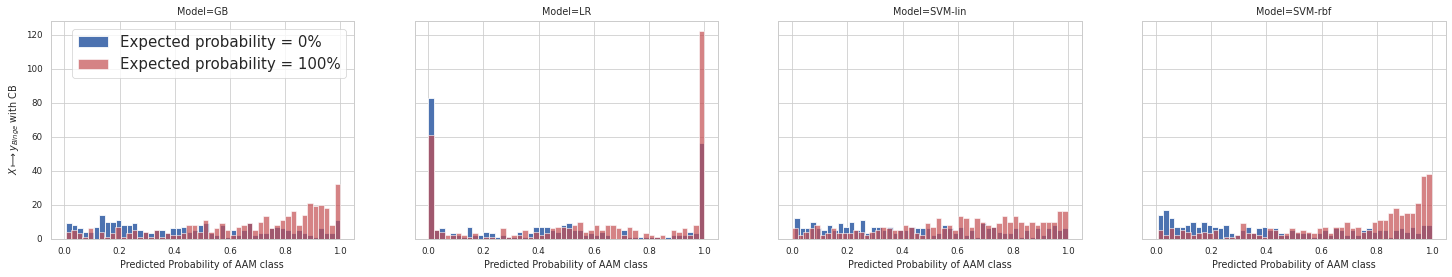

In [46]:
grp_order = ["io", "technique", "model"]
groups = df.groupby(grp_order)   
n_models = len(df["model"].unique())
n_rows = round(len(groups)/n_models)
fig, axes = plt.subplots(n_rows, n_models, 
                         sharex=True, sharey=True,
                         figsize=(25, n_models*n_rows))
axes = np.ravel(axes)
        
for i, (g, dfi) in enumerate(groups):
    ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
    assert ids_all.shape[0] == np.unique(ids_all).shape[0]
    probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
    y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
    assert probs_all.shape[0] == y_all.shape[0]

    prediction=probs_all[:,1]
    ax = axes[i]
    ax.hist(prediction[y_all==0], bins=50, label='Expected probability = 0%')
    ax.hist(prediction[y_all==1], bins=50, label='Expected probability = 100%', alpha=0.7, color='r')
    ax.set_xlabel('Predicted Probability of AAM class')
    if i%n_models == 0:
        ax.set_ylabel("{} with {}".format(remap_io(dfi.iloc[0]), g[1].upper()))
    if i == 0:
        ax.legend(fontsize=15)
    ax.set_title("Model={}".format(g[-1]))
    
plt.show()

### Are all 4 model predictions in agreement with each other?

In [57]:
model_results = load_all_model_preds(df_all_labels)
[display(tp, tp_results) for tp, tp_results in model_results.items()]

'fu3'

,Binge,Sex,Site,GB,GB_prob,LR,LR_prob,SVM-lin,SVM-lin_prob,SVM-rbf,SVM-rbf_prob
ID,,,,,,,,,,,
112288,1.0,Male,Paris,0.0,0.0400,0.0,0.3537,0.0,0.3454,0.0,0.1204
215284,0.0,Female,Nottingham,1.0,0.8881,1.0,0.9995,1.0,0.9608,1.0,0.9901
240546,NaN,Male,Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297685,1.0,Female,Nottingham,1.0,0.7867,1.0,0.5457,1.0,0.7559,1.0,0.9298
308867,1.0,Male,Nottingham,1.0,0.9613,1.0,0.9984,1.0,0.9063,1.0,0.9516
...,...,...,...,...,...,...,...,...,...,...,...
99677574,0.0,Female,Berlin,0.0,0.1233,0.0,0.2481,1.0,0.5701,0.0,0.0700
99873252,1.0,Female,Berlin,0.0,0.0927,0.0,0.0000,0.0,0.0849,0.0,0.0197
99875982,0.0,Female,London,0.0,0.2711,0.0,0.0006,0.0,0.2559,0.0,0.2126


'fu2'

,Binge,Sex,Site,GB,GB_prob,LR,LR_prob,SVM-lin,SVM-lin_prob,SVM-rbf,SVM-rbf_prob
ID,,,,,,,,,,,
112288,1.0,Male,Paris,0.0,0.4060,1.0,0.9054,1.0,0.5103,0.0,0.1789
215284,0.0,Female,Nottingham,1.0,0.9553,1.0,1.0000,1.0,1.0000,1.0,0.8747
240546,NaN,Male,Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297685,1.0,Female,Nottingham,1.0,0.8418,1.0,0.9998,1.0,0.9819,1.0,0.8523
308867,1.0,Male,Nottingham,1.0,0.9847,1.0,0.9995,1.0,0.9470,1.0,0.9964
...,...,...,...,...,...,...,...,...,...,...,...
99677574,0.0,Female,Berlin,0.0,0.2817,0.0,0.0000,0.0,0.0753,0.0,0.0752
99873252,1.0,Female,Berlin,0.0,0.0083,0.0,0.0000,0.0,0.0088,0.0,0.1472
99875982,0.0,Female,London,1.0,0.8281,0.0,0.0000,0.0,0.0595,0.0,0.3109


'bl'

,Binge,Sex,Site,GB,GB_prob,LR,LR_prob,SVM-lin,SVM-lin_prob,SVM-rbf,SVM-rbf_prob
ID,,,,,,,,,,,
112288,1.0,Male,Paris,1.0,0.5923,0.0,0.0000,0.0,0.0470,0.0,0.1126
215284,0.0,Female,Nottingham,1.0,0.9843,1.0,1.0000,1.0,1.0000,1.0,0.7293
240546,NaN,Male,Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297685,1.0,Female,Nottingham,1.0,0.6660,0.0,0.2719,1.0,0.5633,1.0,0.8389
308867,1.0,Male,Nottingham,1.0,0.6876,0.0,0.0080,0.0,0.2462,1.0,0.6333
...,...,...,...,...,...,...,...,...,...,...,...
99677574,0.0,Female,Berlin,0.0,0.1857,1.0,0.8676,1.0,0.6688,0.0,0.4946
99873252,1.0,Female,Berlin,0.0,0.3704,0.0,0.0000,0.0,0.1912,0.0,0.0415
99875982,0.0,Female,London,1.0,0.7046,0.0,0.0036,0.0,0.2788,0.0,0.1455


[None, None, None]

In [59]:
def plot_subject_classes_modelwise(model_results, use_probs):
    # prepare a df for plot_subject_classes() function
    for tp, df_model_results in model_results.items():
        print("=======================================\n              TP = ", tp.upper())
        # drop the probabilities for now
        df_ml =  df_model_results[[LABEL, 'Sex', 'Site']]

        for m in MODELS:
            if use_probs:
                df_ml = df_ml.assign(**{m: df_model_results[m+'_prob']}) #np.nan:1,
            else:
                df_ml = df_ml.assign(**{m: df_model_results[m].map({0:0, 1:2}, na_action='ignore')}) #np.nan:1,

        df_ml = df_ml.dropna()
    #     display(df_ml)

        # plot the correlations between the different models
        corr = df_ml.corr('spearman')
        # Fill diagonal and upper half with NaNs
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        corr[mask] = np.nan
        display((corr.style.background_gradient(vmin=0, vmax=1).highlight_null(null_color='#f1f1f1')).format(precision=2))  # Color NaNs grey

        # visualize the subject class between different models
        sort_order = [LABEL,*MODELS]

        fig, ax = plt.subplots(figsize=(16,len(sort_order)))

        plot_subject_classes(df_ml,
                             ax, confs=['Sex', 'Site'],
                             sort_order=sort_order, 
                             title='Comparison of Model predictions on the same subject',
                             lw=30, cmap=plt.cm.YlGnBu)
        plt.show()

              TP =  FU3


,Binge,GB,SVM-rbf,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
GB,0.41,nan,nan,nan,nan
SVM-rbf,0.42,0.67,nan,nan,nan
SVM-lin,0.29,0.40,0.52,nan,nan
LR,0.27,0.39,0.53,0.67,nan


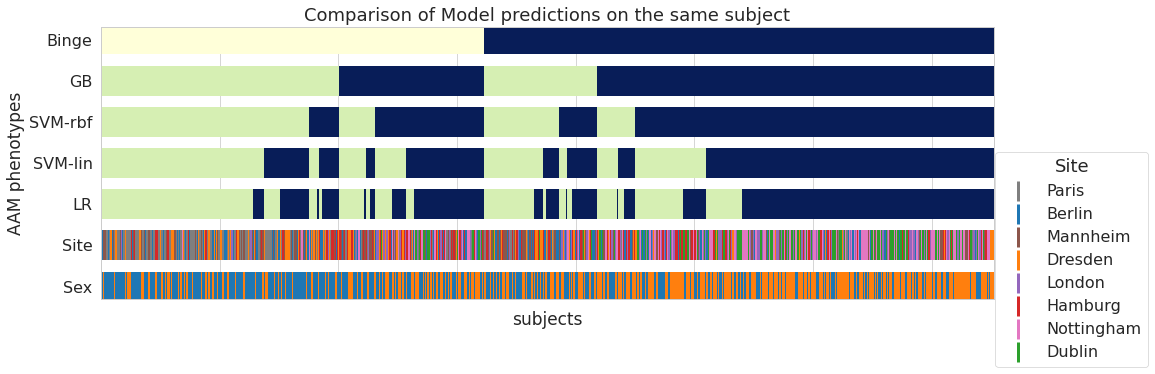

              TP =  FU2


,Binge,GB,SVM-rbf,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
GB,0.42,nan,nan,nan,nan
SVM-rbf,0.45,0.60,nan,nan,nan
SVM-lin,0.36,0.44,0.55,nan,nan
LR,0.31,0.45,0.54,0.88,nan


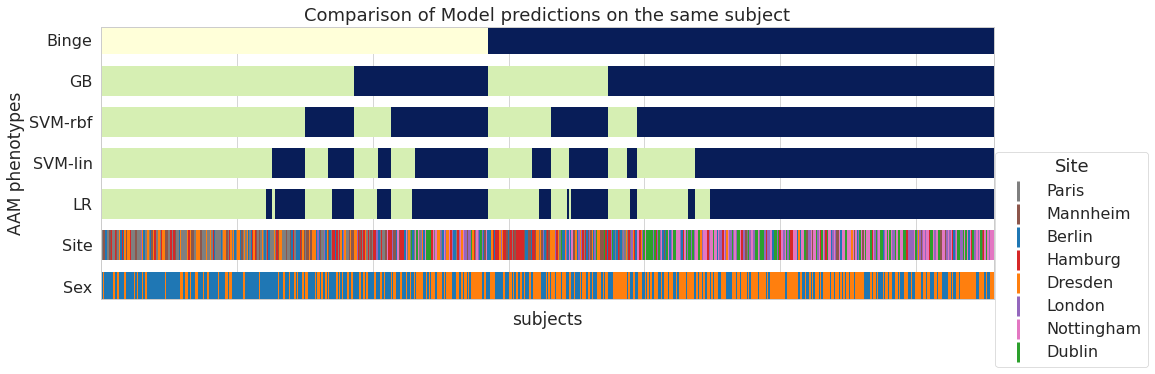

              TP =  BL


,Binge,GB,SVM-rbf,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
GB,0.39,nan,nan,nan,nan
SVM-rbf,0.39,0.60,nan,nan,nan
SVM-lin,0.23,0.45,0.55,nan,nan
LR,0.24,0.37,0.54,0.69,nan


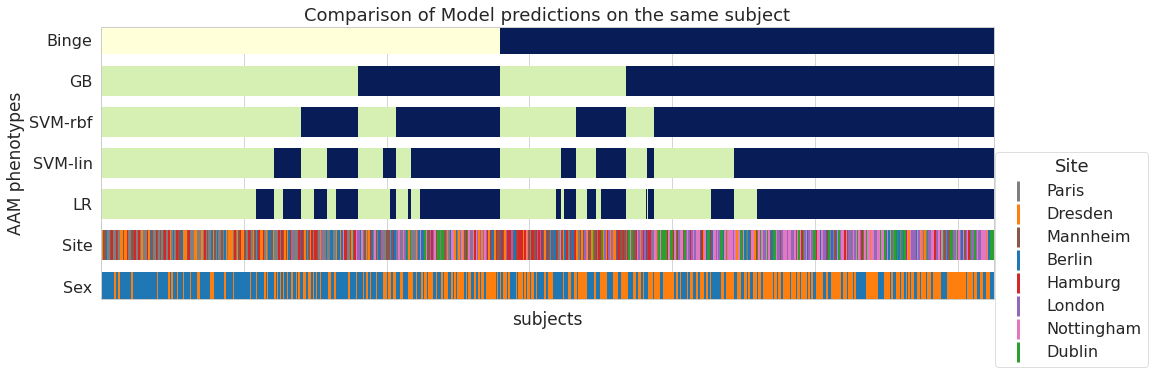

In [61]:
plot_subject_classes_modelwise(model_results, use_probs=False)

### agreement of prediction probabilities

              TP =  FU3


,Binge,GB,SVM-rbf,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
GB,0.42,nan,nan,nan,nan
SVM-rbf,0.44,0.82,nan,nan,nan
SVM-lin,0.28,0.54,0.69,nan,nan
LR,0.25,0.51,0.64,0.81,nan


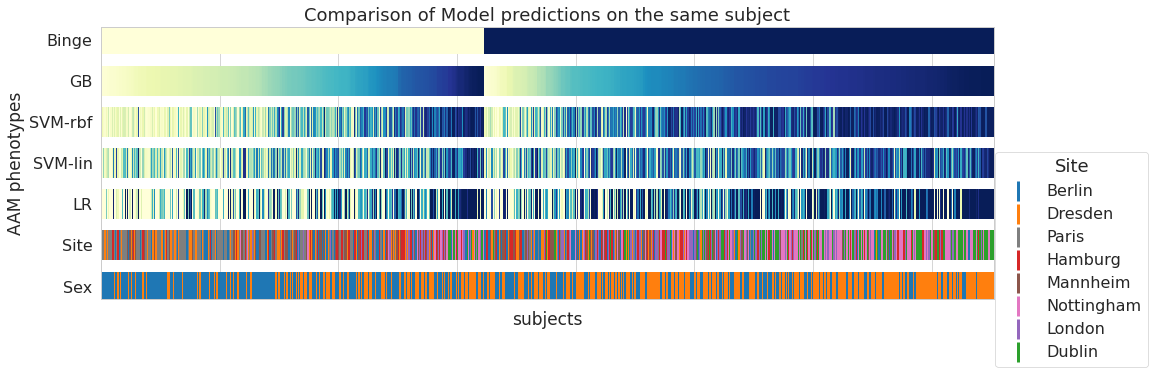

              TP =  FU2


,Binge,GB,SVM-rbf,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
GB,0.47,nan,nan,nan,nan
SVM-rbf,0.51,0.76,nan,nan,nan
SVM-lin,0.39,0.53,0.68,nan,nan
LR,0.36,0.50,0.68,0.92,nan


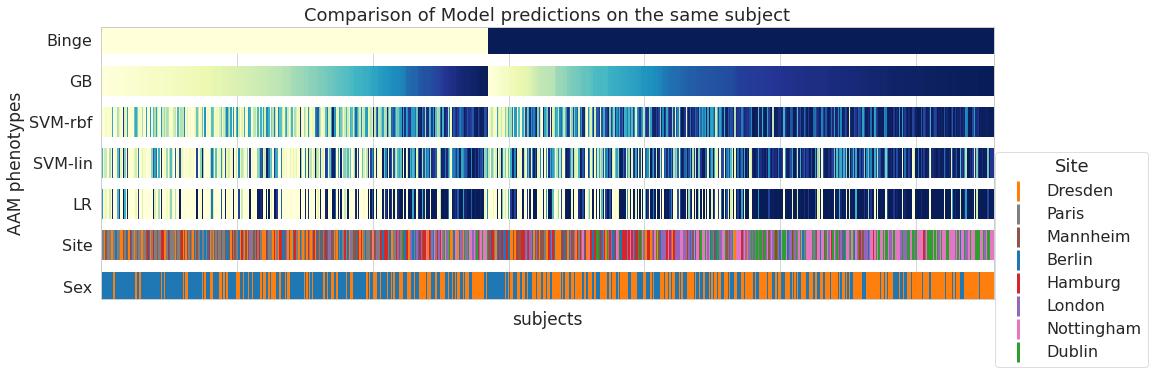

              TP =  BL


,Binge,GB,SVM-rbf,SVM-lin,LR
Binge,nan,nan,nan,nan,nan
GB,0.44,nan,nan,nan,nan
SVM-rbf,0.45,0.75,nan,nan,nan
SVM-lin,0.26,0.54,0.69,nan,nan
LR,0.22,0.44,0.60,0.73,nan


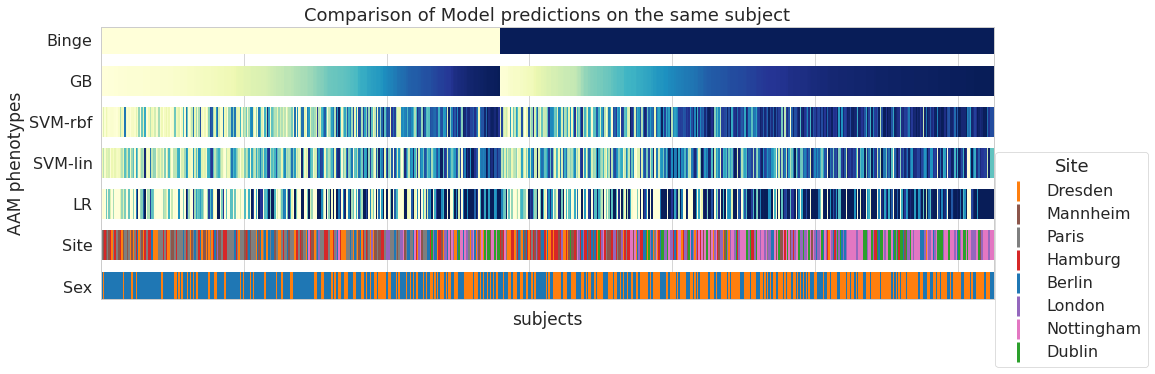

In [62]:
plot_subject_classes_modelwise(model_results, use_probs=True)

In [16]:
# plot the correlations between the different models
corr = df_ml.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.style.background_gradient(axis=None, vmin=0, vmax=1).highlight_null(null_color='#f1f1f1')).set_precision(2)  # Color NaNs grey

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  import sys


,Binge,GB,LR,SVM-lin,SVM-rbf
Binge,nan,nan,nan,nan,nan
GB,0.43,nan,nan,nan,nan
LR,0.26,0.49,nan,nan,nan
SVM-lin,0.28,0.54,0.79,nan,nan
SVM-rbf,0.45,0.82,0.62,0.69,nan


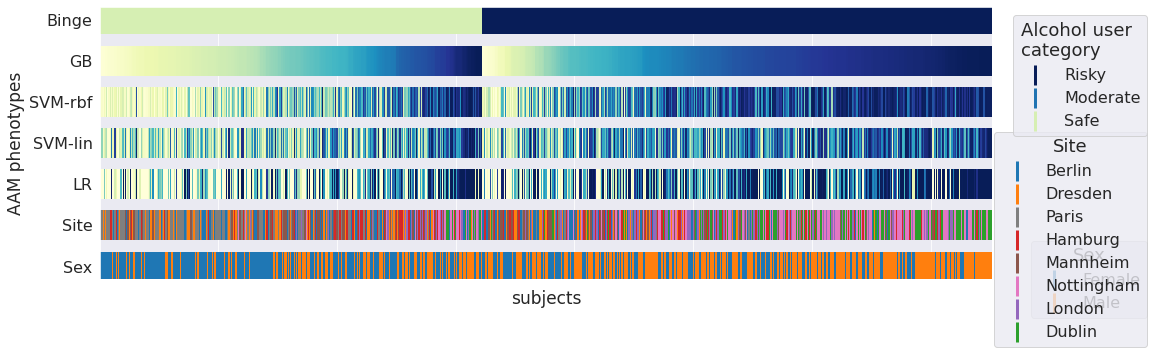

TODOs
1. ~Add holdout set predictions too~
2. run inference on the medium subjects too and see how it looks
3. Visualize the prob. against the Binge continuous variable

## Performance across sites

### main experiment

              TP =  FU3


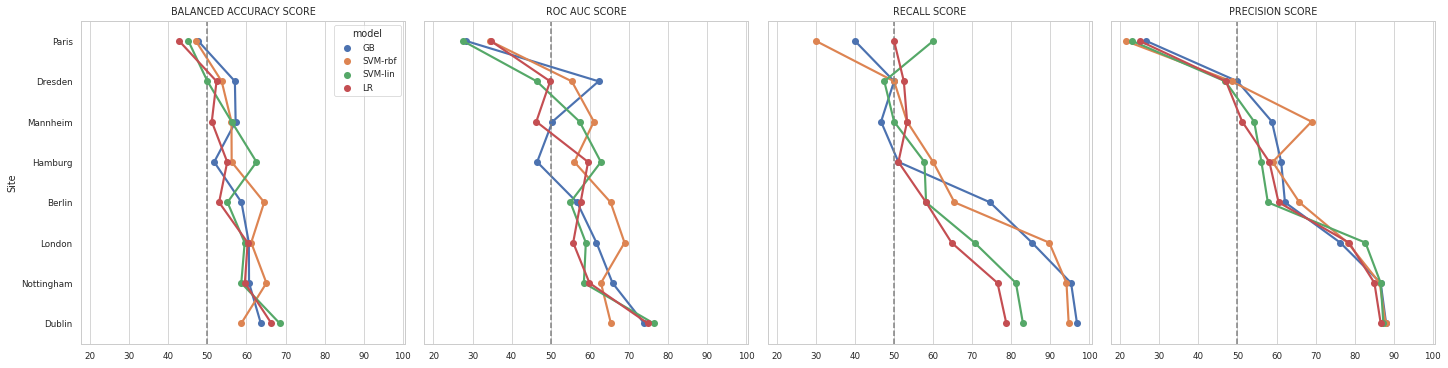

              TP =  FU2


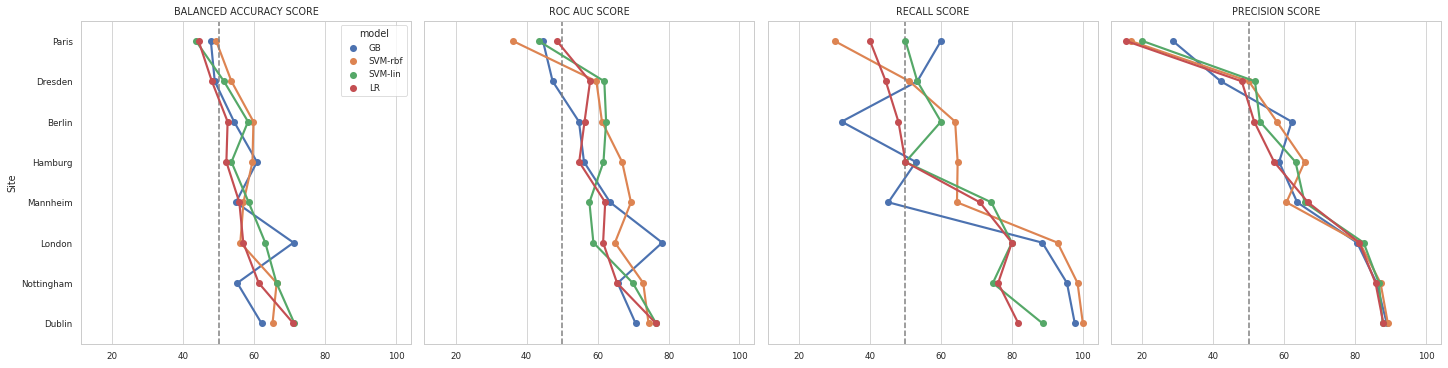

              TP =  BL


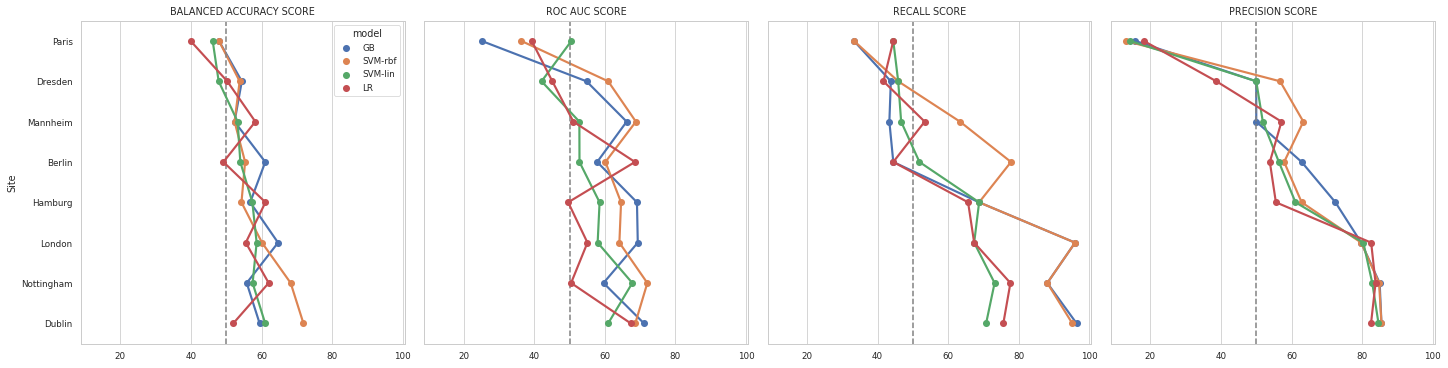

In [63]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score, precision_score
metrics = [balanced_accuracy_score, roc_auc_score, recall_score, precision_score]

for tp, df_model_results in model_results.items():
    print("=======================================\n              TP = ", tp.upper())
    
    sns.set(style='whitegrid', context='paper')
    fig, axes = plt.subplots(1, len(metrics), sharex=True, sharey=True,
                             figsize=(20, 5), constrained_layout=True)

    for i, metric in enumerate(metrics):
        ax = axes[i]
        x = metric.__name__
        data = {}
        for site, dfi in df_model_results.dropna().groupby(['Site']):
            if x=='roc_auc_score':
                scores = {model: metric(dfi[LABEL], dfi[model+'_prob'])*100 for model in MODELS}
            else:
                scores = {model: metric(dfi[LABEL], dfi[model])*100 for model in MODELS}
            data.update({site: scores})
        dfi_computed = pd.DataFrame(data).unstack().reset_index().rename(columns={'level_0':'Site', 'level_1':'model', 0:x})
        sns.pointplot(y="Site", x=x, data=dfi_computed, 
                      order=dfi_computed[["Site", x]].groupby("Site").mean().sort_values(x, ascending=True).index,
                      hue="model", hue_order=MODELS,
                      join=True, palette=sns.color_palette(), 
                      ax=ax)
        ax.axvline(50, lw=1.5, color='gray',linestyle="--")
        ax.set_title(x.upper().replace("_",' '))
        if i>0: ax.set_ylabel("")
        ax.set_xlabel("")
        if i!=0: ax.get_legend().remove()
    plt.show()

### side experiment: _leave-one-site-out_

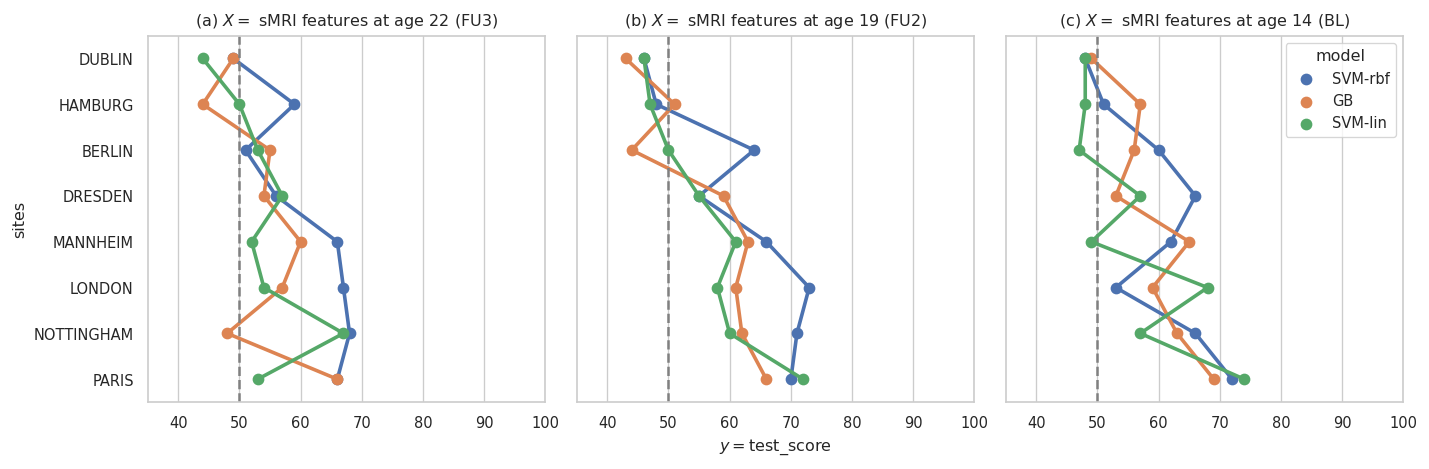

In [70]:
r_path = "fulldata"
df_fulls = [
    (r"(a) $X=$ sMRI features at age 22 (FU3)", pd.read_csv(glob(f"../MLpipelines/results/across_sites/{r_path}-fu3*19a*/*/run.csv")[0])),
    (r"(b) $X=$ sMRI features at age 19 (FU2)", pd.read_csv(glob(f"../MLpipelines/results/across_sites/{r_path}-fu2*19a*/*/run.csv")[0])),
    (r"(c) $X=$ sMRI features at age 14 (BL)",  pd.read_csv(glob(f"../MLpipelines/results/across_sites/{r_path}-bl*19a*/*/run.csv" )[0])),
]
x = "test_score"#'roc_auc'
xlim = [35, 100]

sns.set(style='whitegrid', context='paper')
fig, axes = plt.subplots(1, 3, dpi=120, sharex=True, sharey=True,
                         figsize=(12, 4))

def remap_test_ids_to_site(test_ids):
    test_ids = eval(test_ids)
    # load the information on which site each subject (ID) belong to 
    sub_ids_to_site = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_BIDS/participants_BL.csv", usecols=["ID","site"], index_col=["ID"])
    sites = sub_ids_to_site.loc[test_ids]
    return sites["site"].unique()[0]

models = ["SVM-rbf", "GB", "SVM-lin"]#["LR", "SVM-lin", "SVM-rbf", "GB"]

for i, (title, df) in enumerate(df_fulls):
    ax = axes[i]
    
    df = df[df['model'].isin(models)].copy()
    df[x] = df[x].apply(lambda x:round(x*100))
    df["sites"] = df["test_ids"].apply(remap_test_ids_to_site)
    
    sns.pointplot(y="sites", x=x, hue="model", data=df, 
                  order=df[["sites", x]].groupby("sites").mean().sort_values(x, ascending=True).index,
                  hue_order=models,
                  join=True, palette=sns.color_palette(), 
                  ax=ax) 
    
    ax.axvline(50, lw=1.5, color='gray',linestyle="--")
    ax.set_title(title)   
    ax.set_xlim(xlim)
    if i>0: ax.set_ylabel("")
    ax.set_xlabel("")
    if i==1: ax.set_xlabel(r"$y=$"+x)
    if i!=2: ax.get_legend().remove()
        
plt.tight_layout()
plt.show()